# White-box classifier

## Imports

In [16]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [28]:
df = pd.read_csv('../data/michael_data.csv',sep=' ', names=['issuercountry', 'txvariantcode', 'issuer_id', 'amount', 'currencycode', 'shoppercountry', 'interaction', 'verification', 'cvcresponse', 'creationdate_stamp', 'accountcode', 'mail_id', 'ip_id', 'card_id', 'label'])
df.head()

,issuercountry,txvariantcode,issuer_id,amount,currencycode,shoppercountry,interaction,verification,cvcresponse,creationdate_stamp,accountcode,mail_id,ip_id,card_id,label
0,18,10,465859.0,4370.0,3,26,1,2,1,1.444255e+09,0,32318,45370,1,0
1,68,4,438088.0,13850.0,2,134,1,1,0,1.438942e+09,1,1567,33933,2,0
2,18,12,552213.0,6595.0,3,26,1,1,1,1.437858e+09,0,64936,255836,3,0
3,18,10,492181.0,2895.0,3,26,1,1,1,1.443369e+09,0,95340,242162,4,0
4,55,9,493136.0,223900.0,0,69,1,1,0,1.442077e+09,3,250940,70404,5,0


## Split data and label

In [29]:
X = np.asmatrix(df.drop(['label'], axis=1))
y = df['label']
print(X.shape)
print(y.shape)

(236698, 14)
(236698,)


## Classification: SMOTE + EEN -> 3-NN (10 cross-folded)

### Run classifier

In [76]:
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

clf = make_pipeline(SMOTEENN(random_state=0), KNeighborsClassifier(n_neighbors=3))
y_score = cross_val_predict(clf, X, y, cv=10, method='predict_proba')

### Output confustion matrix

In [77]:
from collections import Counter

# print confusion matrix
y_pred = (y_score[:,1] > 0.5).astype(int)
print(confusion_matrix(y,y_pred))
print(sorted(Counter(y_pred).items()))

[[231012   5341]
 [   276     69]]
[(0, 231288), (1, 5410)]


### Output Precision-Recall Curve

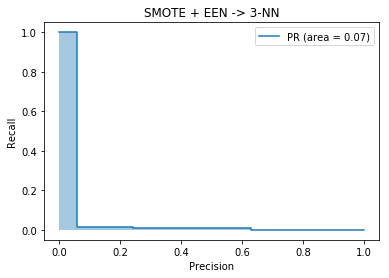

In [78]:
from sklearn.metrics import precision_recall_curve, auc

# calculate PR curve values
prec, rec, thresholds = precision_recall_curve(y, y_score[:,1])

# compute area under PR curve
area =  auc(prec, rec)

# fill area under curve
plt.fill_between(rec, prec, step="mid", alpha=0.4)

# plot PR curve
plt.step(rec, prec, where='mid', label='PR (area = {0:0.2f})'.format(area))
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('SMOTE + EEN -> 3-NN')
plt.legend()
plt.savefig(('pr_curve_white_box_%f' % np.random.rand()).replace('.',''), ext='png', pdi=150)

### Output all metrics

In [79]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.20      0.99      0.44      0.21    236353
          1       0.01      0.20      0.98      0.02      0.44      0.18       345

avg / total       1.00      0.98      0.20      0.99      0.44      0.21    236698

